In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evds import evdsAPI
from datetime import date

In [132]:
evds=evdsAPI('dsIC3fiGlu')


In [133]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4602,22-09-2023,27.0507
4603,25-09-2023,27.1528
4604,26-09-2023,27.2240
4605,27-09-2023,27.2598


In [134]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-05-31,19.719514
2023-06-30,23.106042
2023-07-31,26.470338


In [135]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
206,2023-4,1300.04
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84


In [136]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [137]:

inflation=pd.DataFrame.from_dict({'Tarih':"2023-9",'TÜFE': [1717]})
inflation=pd.concat([enf,inflation],axis=0)
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


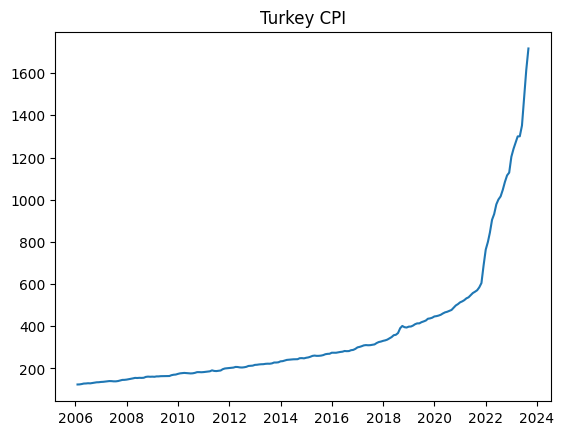

In [138]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure()
plt.title("Turkey CPI")

plt.plot(df)
plt.show()


In [139]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-05-31,19.719514
2023-06-30,23.106042
2023-07-31,26.470338


In [140]:
dates= pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)

            
df6=df6.set_index(dates)

df6["Onceki USD/TL"]=df6["USD/TL"].shift(1)
df6.iloc[0,1]=1.32
df6

,USD/TL,Onceki USD/TL
2006-02-01,1.326535,1.320000
2006-03-01,1.335139,1.326535
2006-04-01,1.337345,1.335139
2006-05-01,1.420659,1.337345
2006-06-01,1.600536,1.420659
...,...,...
2023-05-01,19.719514,19.337032
2023-06-01,23.106042,19.719514
2023-07-01,26.470338,23.106042
2023-08-01,26.999127,26.470338


In [141]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
money

,Tarih,TP_PR_ARZ13
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10
210,2023-8,1.202532e+10


In [142]:
#Cleaning the data

money_supply=pd.DataFrame(money)
money_supply.columns=["Tarih","Para Arzi"]
money_supply["Para Arzi"]=money_supply["Para Arzi"].astype(float)
money_supply


,Tarih,Para Arzi
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10
210,2023-8,1.202532e+10


In [143]:
money_supply=money_supply.set_index(dates)
money_supply["Para Arzi"]=money_supply["Para Arzi"]/1e+08
money_supply
dfn=pd.DataFrame(money_supply)
del dfn["Tarih"]
dfn["Para Arzi Onceki"]=dfn["Para Arzi"].shift(1)
dfn.iloc[0,1]=2.39
dfn


,Para Arzi,Para Arzi Onceki
2006-02-01,2.423895,2.390000
2006-03-01,2.494857,2.423895
2006-04-01,2.521919,2.494857
2006-05-01,2.751947,2.521919
2006-06-01,2.791388,2.751947
...,...,...
2023-05-01,94.093167,95.059993
2023-06-01,108.345324,94.093167
2023-07-01,114.784753,108.345324
2023-08-01,120.253199,114.784753


In [144]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4594,12-09-2023,93.58
4595,13-09-2023,93.04
4596,14-09-2023,95.20
4597,15-09-2023,95.55


In [145]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle

brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-05-31,75.466000
2023-06-30,74.839091
2023-07-31,80.108095


In [146]:

brent1=pd.DataFrame(brent)
brent1.columns=["Brent"]
brent1


,Brent
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-05-31,75.466000
2023-06-30,74.839091
2023-07-31,80.108095


In [147]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)

df14["Brent"]=brent1["Brent"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

C:\Users\Bora\AppData\Local\Temp\ipykernel_1112\3566834801.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Brent
TIME,
2006-02-01,60.210000
2006-03-01,62.064783
2006-04-01,70.260000
2006-05-01,69.776957
2006-06-01,68.555909
...,...
2023-05-01,75.466000
2023-06-01,74.839091
2023-07-01,80.108095


In [148]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
207,2023-5,8.804344e+09
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09


In [149]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
207,2023-5,88.043441
208,2023-6,95.646045
209,2023-7,98.468952
210,2023-8,99.238055


In [150]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3

C:\Users\Bora\AppData\Local\Temp\ipykernel_1112\2513009782.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Kredi
TIME,
2006-02-01,1.381847
2006-03-01,1.481222
2006-04-01,1.527510
2006-05-01,1.664881
2006-06-01,1.740395
...,...
2023-05-01,88.043441
2023-06-01,95.646045
2023-07-01,98.468952


In [151]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)


C:\Users\Bora\AppData\Local\Temp\ipykernel_1112\635047745.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


Text(0.5, 1.0, 'TCMB Fonlama Faizi')

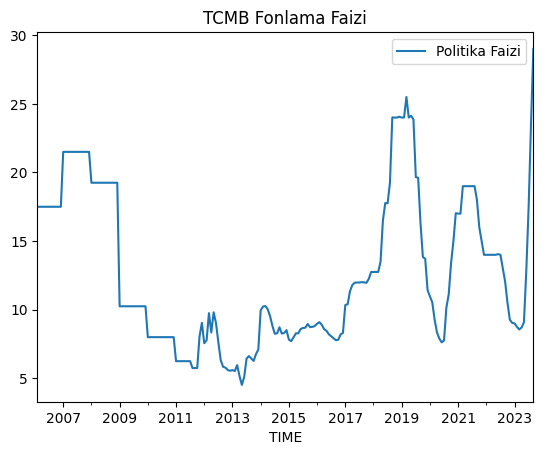

In [152]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1)
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz.plot(label="TCMB Fonlama Faizi")
plt.title("TCMB Fonlama Faizi")

In [153]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1))
kfaiz

,Kredi Faizi
2006-02-01,17.297500
2006-03-01,17.008000
2006-04-01,16.207500
2006-05-01,16.300000
2006-06-01,19.670000
...,...
2023-05-01,32.022500
2023-06-01,38.560000
2023-07-01,45.825000
2023-08-01,45.765000


In [154]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz

,Tarih,TP_TRY_MT02
0,2006-2,15.7600
1,2006-3,15.3300
2,2006-4,15.1750
3,2006-5,14.9250
4,2006-6,15.5840
...,...,...
207,2023-5,31.4625
208,2023-6,39.5920
209,2023-7,33.1250
210,2023-8,29.4125


In [155]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=3)
del mfaiz["YEARWEEK"]
mfaiz['Tarih'] = pd.to_datetime(mfaiz['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
mfaiz.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
mfaiz = mfaiz.resample('M').mean()
mfaiz.columns=["Mevduat Faizi"]
mfaiz=mfaiz.astype(float)
mfaiz=mfaiz.set_index(pd.date_range('2006-02-01','2023-10-01' , freq='1M')-pd.offsets.MonthBegin(1))
mfaiz

,Mevduat Faizi
2006-02-01,15.7600
2006-03-01,15.3300
2006-04-01,15.1750
2006-05-01,14.9250
2006-06-01,15.5840
...,...
2023-05-01,31.4625
2023-06-01,39.5920
2023-07-01,33.1250
2023-08-01,29.4125


In [156]:
X=pd.concat([df6["USD/TL"].rolling(3).mean().tail(210),dfn["Para Arzi"].rolling(2).mean().tail(210),df14.Brent.rolling(2).mean().tail(210),df3.Kredi.rolling(2).mean().tail(210),pfaiz["Politika Faizi"].rolling(2).mean().tail(210),kfaiz["Kredi Faizi"].rolling(2).mean().tail(210)],axis=1)




In [157]:
y=pd.DataFrame(df["CPI"])
y["CPI"]=y["CPI"].astype(float)
y=y.tail(210)
y


,CPI
2006-04-01,125.84
2006-05-01,128.20
2006-06-01,128.63
2006-07-01,129.72
2006-08-01,129.15
...,...
2023-05-01,1300.60
2023-06-01,1351.59
2023-07-01,1479.84
2023-08-01,1614.31


In [158]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [159]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()

# Modelin özetini görüntüleyin
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     9338.
Date:                Thu, 28 Sep 2023   Prob (F-statistic):          1.48e-179
Time:                        15:41:23   Log-Likelihood:                -609.85
No. Observations:                 147   AIC:                             1234.
Df Residuals:                     140   BIC:                             1255.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             79.9414      7.289     10.

In [160]:
results.params

const             79.941413
USD/TL            12.490322
Para Arzi          7.955360
Brent              0.192666
Kredi              2.090008
Politika Faizi    -2.004824
Kredi Faizi        1.991348
dtype: float64

In [161]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
train_data = df6['USD/TL'][:len(df6)-12]
test_data = df6['USD/TL'][len(df6)-12:]


ar_model = AutoReg(train_data, lags=12)
ar_fit = ar_model.fit()
ar_forecast = ar_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
print(np.sqrt(mean_squared_error(test_data, ar_forecast)))





1.636503950079591


c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


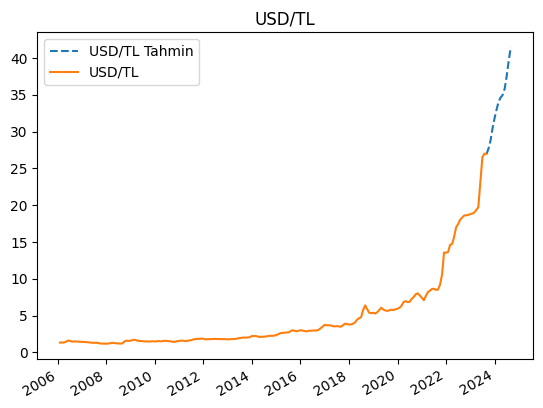

In [162]:
# AR modeli ile tüm veri seti üzerinde eğitim
full_ar_model = AutoReg(df6['USD/TL'], lags=12)
full_ar_fit = full_ar_model.fit()

# Önümüzdeki 12 ay için tahmin yapma
full_ar_forecast = full_ar_fit.predict(start=len(df6), end=len(df6)+11)

usdtahmin=pd.DataFrame({26.94},index=["2023-09-01 00:00:00"])
usdtahmin=pd.concat([usdtahmin,full_ar_forecast],axis=0)
usdtahmin.columns=["USD Tahmin"]
usdtahmin["USD Tahmin"]=usdtahmin["USD Tahmin"].astype(float)
usdtahmin=usdtahmin.set_index(pd.date_range('2023-09-01','2024-10-01' , freq='1M')-pd.offsets.MonthBegin(1))
plt.plot(usdtahmin,"--",label="USD/TL Tahmin")
df6["USD/TL"].plot(label="USD/TL")
plt.title("USD/TL")
plt.legend()


c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Bora\AppDa

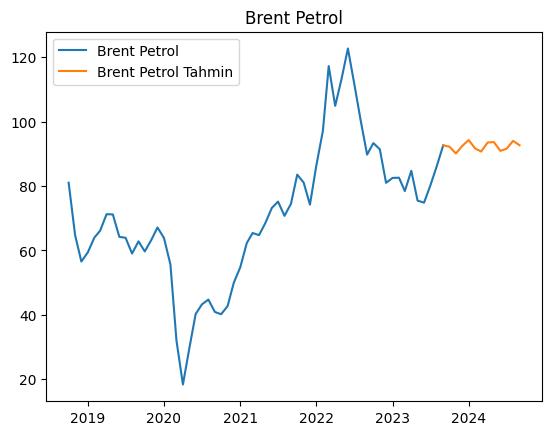

In [163]:
# Modeli eğitim verisi üzerinde eğitme
model = ARIMA(df14["Brent"], order=(4,1,2))
# Modeli tekrar eğitim verisi üzerinde eğitme
model_fit = model.fit()

# Tahmin yapma
forecast = model_fit.forecast(steps=12)
predictions = forecast.values
predictions = pd.DataFrame(predictions,index=pd.date_range('2023-10-01', periods=12, freq='M'))
brenttahmin=pd.DataFrame({92.64},index=["2023-09-01"])
brenttahmin=pd.concat([brenttahmin,predictions],axis=0)
brenttahmin.columns=["Brent Tahmin"]
brenttahmin=brenttahmin.set_index(pd.date_range('2023-09-01','2024-10-01' , freq='1M')-pd.offsets.MonthBegin(1))
plt.plot(df14.tail(60),label="Brent Petrol")
plt.plot(brenttahmin.tail(60),label="Brent Petrol Tahmin")
plt.title("Brent Petrol")
plt.legend()

c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


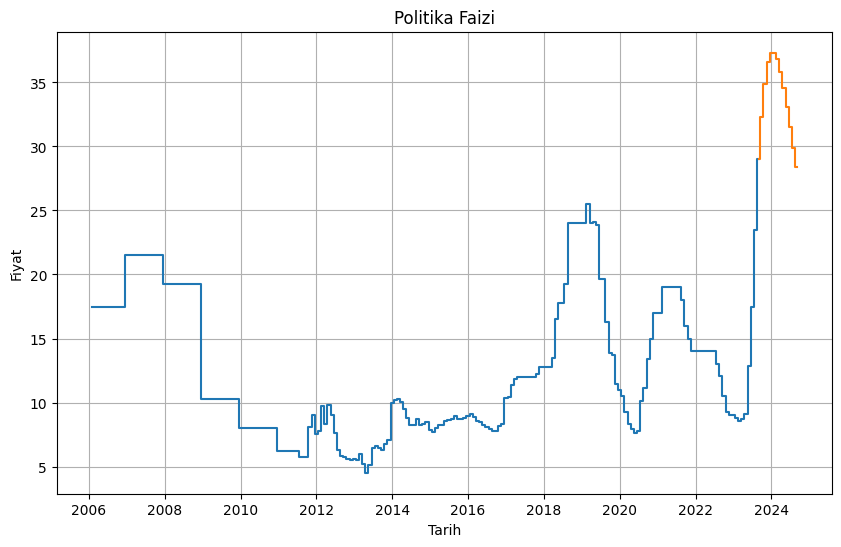

In [164]:
# En uygun parametrelerle ARIMA modelini eğitme
optimal_model = ARIMA(pfaiz, order=(4,1,1))
optimal_model_fit = optimal_model.fit()

# Gelecek 12 ay için tahmin yapma
optimal_future_forecast = optimal_model_fit.forecast(steps=12)
optimal_future_predictions = optimal_future_forecast.values

optimal_future_predictions = pd.DataFrame(optimal_future_predictions,index=pd.date_range('2023-10-01', periods=12, freq='M'))

faiztahmin=pd.DataFrame(optimal_future_predictions)
faiztahmin.columns=["Politika Faizi"]
faiztahmin=faiztahmin.set_index(pd.date_range('2023-10-01','2024-10-01' , freq='1M')-pd.offsets.MonthBegin(1))
faiztahmin=pd.concat([pfaiz,faiztahmin],axis=0)
kademeli = [faiztahmin.iloc[0]]
for i in range(1, len(faiztahmin)):
    kademeli.append(faiztahmin.iloc[i])

# Tarihleri x ekseni olarak ve kademeli fiyatları y ekseni olarak kullanarak kademeli bir grafik çiz
plt.figure(figsize=(10, 6))
plt.step(faiztahmin[:212].index, kademeli[:212], where='mid', linestyle='-')
plt.step(faiztahmin[211:].index, kademeli[211:], where='mid', linestyle='-')
plt.title('Politika Faizi')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.grid(True)


In [165]:
# En uygun parametrelerle ARIMA modelini eğitme
optimal_model = ARIMA(dfn["Para Arzi Onceki"], order=(4,3,4))
optimal_model_fit = optimal_model.fit()

# Gelecek 12 ay için tahmin yapma
optimal_future_forecast = optimal_model_fit.forecast(steps=12)
optimal_future_predictions = optimal_future_forecast.values

optimal_future_predictions = pd.DataFrame(optimal_future_predictions,index=pd.date_range('2023-10-01', periods=12, freq='M'))
paraarzitahmin=pd.DataFrame({120.25},index=["2023-09-01"])
paraarzitahmin=pd.concat([paraarzitahmin,optimal_future_predictions],axis=0)
paraarzitahmin.columns=["Para Arzı Tahmin"]
paraarzitahmin=paraarzitahmin.set_index(pd.date_range('2023-09-01','2024-10-01' , freq='1M')-pd.offsets.MonthBegin(1))
paraarzitahmin


c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Para Arzı Tahmin
2023-09-01,120.250000
2023-10-01,126.835360
2023-11-01,133.666626
2023-12-01,136.996354
2024-01-01,146.528597
2024-02-01,149.748230
2024-03-01,158.734451
2024-04-01,164.223670
2024-05-01,172.422555
2024-06-01,179.063276


In [166]:
# En uygun parametrelerle ARIMA modelini eğitme
optimal_model = ARIMA(df3["Kredi"], order=(4,3,4))
optimal_model_fit = optimal_model.fit()

# Gelecek 12 ay için tahmin yapma
optimal_future_forecast = optimal_model_fit.forecast(steps=11)
optimal_future_predictions = optimal_future_forecast.values

optimal_future_predictions = pd.DataFrame(optimal_future_predictions,index=pd.date_range('2023-10-01', periods=11, freq='M'))
kreditahmin=pd.DataFrame({101.63},index=["2023-09-01"])
kreditahmin=pd.concat([kreditahmin,optimal_future_predictions],axis=0)
kreditahmin.columns=["Kredi Tahmin"]
kreditahmin=kreditahmin.set_index(pd.date_range('2023-09-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1))
kreditahmin

c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Bora\AppData\Local\Programs

,Kredi Tahmin
2023-09-01,101.630000
2023-10-01,104.552671
2023-11-01,106.433199
2023-12-01,109.584904
2024-01-01,112.674150
2024-02-01,114.245810
2024-03-01,117.056353
2024-04-01,120.606404
2024-05-01,122.417586
2024-06-01,124.770029


In [167]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
optimal_model = SARIMAX(mfaiz, seasonal_order=(2,1,2,12))
optimal_model_fit = optimal_model.fit()

# Gelecek 12 ay için tahmin yapma
optimal_future_forecast = optimal_model_fit.forecast(steps=12)
optimal_future_forecast=pd.DataFrame(optimal_future_forecast)
optimal_future_forecast.columns=["Mevduat Faizi Tahmin"]
mfaiztahmin=pd.DataFrame({41},index=["2023-09-01"])
mfaiztahmin.columns=["Mevduat Faizi Tahmin"]

mfaiztahmin=pd.concat([mfaiztahmin,optimal_future_forecast],axis=0)
mfaiztahmin=mfaiztahmin.set_index(pd.date_range('2023-09-01','2024-10-01' , freq='1M')-pd.offsets.MonthBegin(1))
mfaiztahmin

c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


,Mevduat Faizi Tahmin
2023-09-01,41.000000
2023-10-01,39.773890
2023-11-01,39.242176
2023-12-01,39.579767
2024-01-01,39.803675
2024-02-01,38.953672
2024-03-01,38.590244
2024-04-01,38.943378
2024-05-01,38.678402
2024-06-01,38.429537


In [168]:
# En uygun parametrelerle ARIMA modelini eğitme
optimal_model = ARIMA(kfaiz["Kredi Faizi"], order=(1,1,0))
optimal_model_fit = optimal_model.fit()

# Gelecek 12 ay için tahmin yapma
optimal_future_forecast = optimal_model_fit.forecast(steps=11)
optimal_future_predictions = optimal_future_forecast.values

optimal_future_predictions = pd.DataFrame(optimal_future_predictions,index=pd.date_range('2023-10-01', periods=11, freq='M'))
optimal_future_predictions.columns=["Kredi Faizi Tahmin"]
kfaiztahmin=pd.DataFrame({55.57},index=["2023-09-01"])
kfaiztahmin.columns=["Kredi Faizi Tahmin"]

kfaiztahmin=pd.concat([kfaiztahmin,optimal_future_predictions],axis=0)
kfaiztahmin=kfaiztahmin.set_index(pd.date_range('2023-09-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1))
kfaiztahmin

c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Kredi Faizi Tahmin
2023-09-01,55.570000
2023-10-01,60.732723
2023-11-01,63.442244
2023-12-01,64.866105
2024-01-01,65.614347
2024-02-01,66.007551
2024-03-01,66.214180
2024-04-01,66.322764
2024-05-01,66.379826
2024-06-01,66.409812


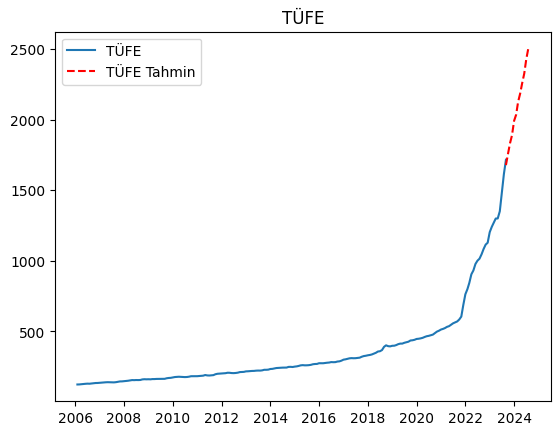

In [169]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()










res2=[]



for i in range(12):
    res2.append(results.params["const"]+results.params["USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi"]*paraarzitahmin["Para Arzı Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin"][i]+results.params["Brent"]*brenttahmin["Brent Tahmin"][i]+results.params["Politika Faizi"]*faiztahmin["Politika Faizi"][i]+results.params["Kredi Faizi"]*kfaiztahmin["Kredi Faizi Tahmin"][i])
   
    



df9=pd.DataFrame()
dates=pd.date_range('2023-09-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
df9["TÜFE"]=res2
df9['TIME']=dates
df9=df9.set_index(dates)
del df9['TIME']
plt.plot(df["CPI"],label="TÜFE")
plt.plot(df9,"--",label="TÜFE Tahmin",color="red")
plt.title("TÜFE")
plt.legend()

In [170]:

data=pd.DataFrame()
dates=pd.date_range(start='2006-02-01', periods=211, freq='M')

# Veriyi bir veri çerçevesine yerleştirme

pfaiz=pfaiz.head(211)
mfaiz=mfaiz.head(211)
df6=df6.head(211)
dfn=dfn.head(211)
df14=df14.head(211)
df3=df3.head(211)
df=df.head(211)

pfaiz=pfaiz.set_index(dates)
mfaiz=mfaiz.set_index(dates)
df6=df6.set_index(dates)
dfn=dfn.set_index(dates)
df14=df14.set_index(dates)
df3=df3.set_index(dates)
df=df.set_index(dates)


data["USD/TL"]=df6["USD/TL"]
data["Para Arzı"]=dfn["Para Arzi"]
data["Brent"]=df14["Brent"]
data["Kredi"]=df3["Kredi"]
data["TÜFE"]=df["CPI"]
data



,USD/TL,Para Arzı,Brent,Kredi,TÜFE
2006-02-28,1.326535,2.423895,60.210000,1.381847,123.84
2006-03-31,1.335139,2.494857,62.064783,1.481222,124.18
2006-04-30,1.337345,2.521919,70.260000,1.527510,125.84
2006-05-31,1.420659,2.751947,69.776957,1.664881,128.20
2006-06-30,1.600536,2.791388,68.555909,1.740395,128.63
...,...,...,...,...,...
2023-04-30,19.337032,95.059993,84.739474,85.721139,1300.04
2023-05-31,19.719514,94.093167,75.466000,88.043441,1300.60
2023-06-30,23.106042,108.345324,74.839091,95.646045,1351.59
2023-07-31,26.470338,114.784753,80.108095,98.468952,1479.84


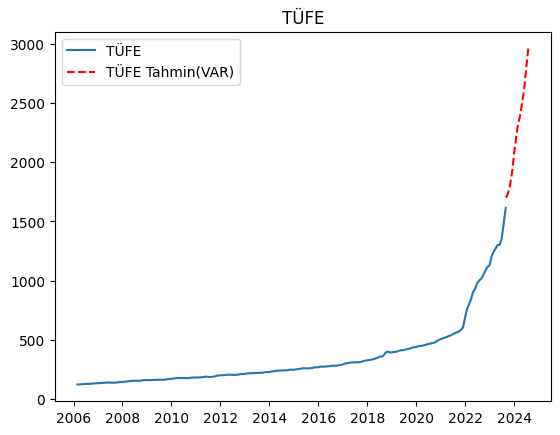

In [171]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

model = sm.tsa.VAR(data)
# Modeli uyarlayın
results = model.fit(ic="hqic",maxlags=5)  # İhtiyaca göre maksimum gecikme düzeyini ayarlayabilirsiniz

# Tahminler yapın (örneğin, 12 aylık öngörü)
forecast_horizon = 12
forecast = results.forecast(y=results.endog, steps=forecast_horizon)

forecast=pd.DataFrame(forecast[:,4])
forecast.columns=["TÜFE"]
forecast=forecast.set_index(pd.date_range('2023-09-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1))
plt.plot(df["CPI"],label="TÜFE")
plt.plot(forecast,"--",label="TÜFE Tahmin(VAR)",color="red")
plt.title("TÜFE")
plt.legend()




In [172]:
dates=pd.date_range('2023-09-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
tahmin5=pd.DataFrame(forecast["TÜFE"])
tahmin5=tahmin5.set_index(dates)
tahmin5.columns=["TÜFE"]
tahmin5

,TÜFE
2023-09-01,1699.836312
2023-10-01,1732.002049
2023-11-01,1801.049779
2023-12-01,1905.326148
2024-01-01,2065.173462
2024-02-01,2203.528872
2024-03-01,2323.153193
2024-04-01,2393.861920
2024-05-01,2500.276852
2024-06-01,2617.931695


In [173]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa



# Parametrelerin zaman içinde değişeceği random walk süreçlerini oluşturun
param_dolar = np.cumsum(np.random.randn(211))  # Dolar parametresi için




# Stokastik volatiliteyi oluşturun (varyans da zaman içinde random walk)
volatility = np.exp(np.cumsum(np.random.randn(211)))  # Logaritmik volatiliteyi oluşturun

# Tüm bu oluşturulan süreçleri bir DataFrame'e ekleyin
data['Param_Dolar'] = param_dolar
data['Volatility'] = volatility

model_data = data
model = tsa.VAR(model_data)
results=[]
forecast=[]
for i in range(500):
    results.append(model.fit(ic="aic", maxlags=2))
    forecast_horizon = 12
    forecast_input = model_data.iloc[-4:, :].values  # Son 4 gözlemi kullanarak tahmin ediyoruz
    forecast.append(results[i].forecast(y=forecast_input, steps=forecast_horizon))

# Tahmin edilen değerlerin 4. sütununu (indeksi 3) alarak ortalama hesaplayın
ortalama_array = np.mean([f[:, 4] for f in forecast], axis=0)

ortalama_array
    


    









array([1690.27394713, 1735.25173124, 1778.8656481 , 1838.45783541,
       1922.11136999, 2029.50558707, 2150.49570194, 2271.32610573,
       2384.06032898, 2491.54197308, 2603.97197647, 2731.24761284])

In [174]:
dates=pd.date_range('2023-09-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
tahmin6=pd.DataFrame(ortalama_array)
tahmin6=tahmin6.set_index(dates)
tahmin6.columns=["TÜFE"]
tahmin6

,TÜFE
2023-09-01,1690.273947
2023-10-01,1735.251731
2023-11-01,1778.865648
2023-12-01,1838.457835
2024-01-01,1922.111370
2024-02-01,2029.505587
2024-03-01,2150.495702
2024-04-01,2271.326106
2024-05-01,2384.060329
2024-06-01,2491.541973


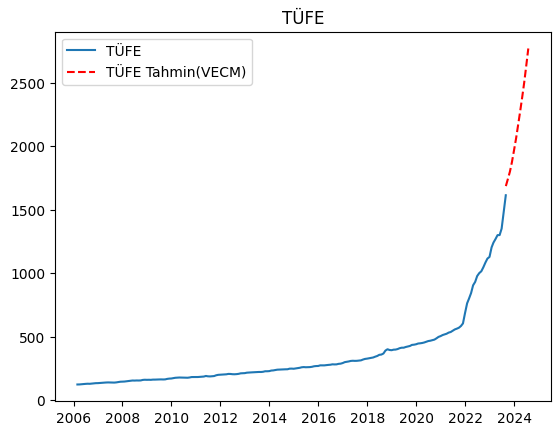

In [175]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as sm
data=pd.DataFrame()
dates=pd.date_range(start='2006-02-01', periods=211, freq='M')

# Veriyi bir veri çerçevesine yerleştirme


data["Döviz Kuru"]=df6["Onceki USD/TL"]
data["Para Arzı"]=dfn["Para Arzi Onceki"]
data["Petrol"]=df14["Brent"]
data["Kredi Hacmi"]=df3["Kredi"]
data["TÜFE"]=df["CPI"]
data.set_index(dates, inplace=True)
data.dropna(inplace=True)
data=data.head(211)
data

model = sm.VECM(data, k_ar_diff=1, coint_rank=5, deterministic="co",seasons=12)
results = model.fit()

# TÜFE'nin gelecekteki değerlerini tahmin et
tahmin = results.predict(steps=12, alpha=0.05)

tahmin1=pd.DataFrame(tahmin[0],columns=['Döviz Kuru','Para Arzi','Petrol','Kredi Hacmi','TÜFE'])


tahmin2=pd.DataFrame(tahmin[1],columns=['Döviz Kuru','Para Arzi','Petrol','Kredi Hacmi','TÜFE'])
tahmin3=pd.DataFrame(tahmin[2],columns=['Döviz Kuru','Para Arzi','Petrol','Kredi Hacmi','TÜFE'])

tahmin4=pd.DataFrame()
tahmin4["TÜFE"]=(tahmin1["TÜFE"]+tahmin2["TÜFE"]+tahmin3["TÜFE"])/3
dates=pd.date_range('2023-09-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
tahmin4=tahmin4.set_index(dates)
plt.plot(df["CPI"],label="TÜFE")
plt.plot(tahmin4,"--",label="TÜFE Tahmin(VECM)",color="red")
plt.title("TÜFE")
plt.legend()

In [176]:
dff=pd.concat([df["CPI"].head(211),df9["TÜFE"]],axis=0)
dff=pd.DataFrame(dff)
dff.columns=["CPI"]



dfas4=pd.concat([df["CPI"].head(211),tahmin4["TÜFE"]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=["CPI"]

dfas5=pd.concat([df["CPI"].head(211),tahmin5["TÜFE"]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=["CPI"]




dfas6=pd.concat([df["CPI"].head(211),tahmin6["TÜFE"]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=["CPI"]
dfas6







,CPI
2006-02-28,123.840000
2006-03-31,124.180000
2006-04-30,125.840000
2006-05-31,128.200000
2006-06-30,128.630000
...,...
2024-04-01,2271.326106
2024-05-01,2384.060329
2024-06-01,2491.541973
2024-07-01,2603.971976


In [177]:
import pandas as pd

# Örnek DataFrame oluşturalım (gerçek verilere göre değiştirin)
# Diyelim ki veriler 'tufe' sütununda ve 'tarih' sütununda saklanıyor




# 12 ay önceki tüfe değerlerini içeren bir sütun ekleyin
dff['onceki_yil_tufe'] = dff['CPI'].shift(12)
dfas4['onceki_yil_tufe'] = dfas4['CPI'].shift(12)
dfas5['onceki_yil_tufe'] = dfas5['CPI'].shift(12)
dfas6['onceki_yil_tufe'] = dfas6['CPI'].shift(12)


# Yüzde artışı hesaplayın ve 'yillik_enflasyon_orani' sütununu ekleyin
dff['yillik_enflasyon_orani'] = ((dff['CPI'] / dff['onceki_yil_tufe']) - 1) * 100
dfas4['yillik_enflasyon_orani'] = ((dfas4['CPI'] / dfas4['onceki_yil_tufe']) - 1) * 100
dfas5['yillik_enflasyon_orani'] = ((dfas5['CPI'] / dfas5['onceki_yil_tufe']) - 1) * 100
dfas6['yillik_enflasyon_orani'] = ((dfas6['CPI'] / dfas6['onceki_yil_tufe']) - 1) * 100
# NaN değerleri (ilk 12 ay) veriden çıkarın
dff.dropna(inplace=True)
dfas4.dropna(inplace=True)
dfas5.dropna(inplace=True)
dfas6.dropna(inplace=True)




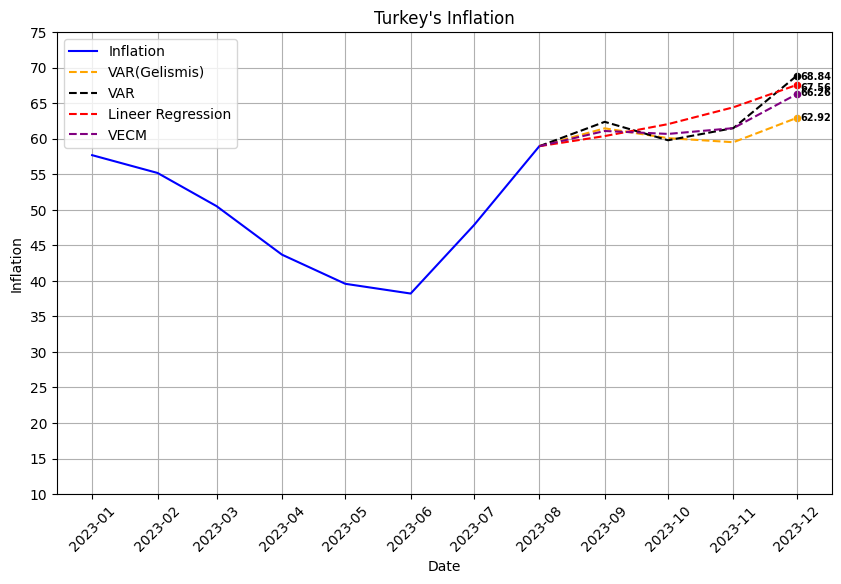

In [178]:
dates=pd.date_range('2007-02-01','2024-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
dff=dff.set_index(dates)
dfas4=dfas4.set_index(dates)
dfas5=dfas5.set_index(dates)
dfas6=dfas6.set_index(dates)






# Grafik çizdirelim
plt.figure(figsize=(10, 6))
plt.plot(dff.iloc[191:199]["yillik_enflasyon_orani"], label='Inflation', color='blue')
#plt.plot(dfas2.iloc[198:203]["yillik_enflasyon_orani"],'--', label='Forecast with monetary tightening', color='green')
plt.plot(dfas6.iloc[198:203]["yillik_enflasyon_orani"],'--',label='VAR(Gelismis)', color='orange'    )
plt.plot(dfas5.iloc[198:203]["yillik_enflasyon_orani"],'--',label='VAR', color='black')
plt.plot(dff.iloc[198:203]["yillik_enflasyon_orani"],'--',label='Lineer Regression', color='red')
plt.plot(dfas4.iloc[198:203]["yillik_enflasyon_orani"],'--',label='VECM', color='purple')



plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dff.iloc[191:].index, dff.iloc[191:].index.strftime('%Y-%m'), rotation=45)
y_max = int(max(dff["yillik_enflasyon_orani"].iloc[191:]))
y_min = 10
y_interval = 0.5
y_ticks = [y_min]
while y_ticks[-1] < y_max:
    y_ticks.append(y_ticks[-1] + 5)

son_dort_veri=dff["yillik_enflasyon_orani"].iloc[202:203]
son_dort_veri3=dfas4["yillik_enflasyon_orani"].iloc[202:203]
son_dort_veri4=dfas5["yillik_enflasyon_orani"].iloc[202:203]
son_dort_veri5=dfas6["yillik_enflasyon_orani"].iloc[202:203]


# Y ekseni etiketlerini ayarlama
for i, v in enumerate(son_dort_veri):
    plt.annotate(f'{v:.2f}', (son_dort_veri.index[i], v), xytext=(3, -4), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri.index,son_dort_veri,color='red',s=20)


for i, v in enumerate(son_dort_veri3):
    plt.annotate(f'{v:.2f}', (son_dort_veri3.index[i], v), xytext=(3, -1), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri3.index,son_dort_veri3,color='purple',s=20)

for i,v in enumerate(son_dort_veri4):
    plt.annotate(f'{v:.2f}', (son_dort_veri4.index[i], v), xytext=(3, -3), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri4.index,son_dort_veri4,color='black',s=20)


for i,v in enumerate(son_dort_veri5):
    plt.annotate(f'{v:.2f}', (son_dort_veri5.index[i], v), xytext=(3, -2), textcoords='offset points', fontsize=7,
                 color='black', fontweight='bold')
    plt.scatter(son_dort_veri5.index,son_dort_veri5,color='orange',s=20)

#for i,v in enumerate(son_dort_veri6):
 #   plt.annotate(f'{v:.2f}', (son_dort_veri5.index[i], v), xytext=(3, -4), textcoords='offset points', fontsize=7,
  #               color='black', fontweight='bold')
   # plt.scatter(son_dort_veri6.index,son_dort_veri6,color='green',s=20)






# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation")
plt.legend()
plt.grid(True)
plt.show()


In [179]:
lineer_regression=(((dff.loc['2023-09-01']["CPI"]/dff.loc['2023-08-01']["CPI"])-1)*100)
var=(((dfas6.loc['2023-09-01']["CPI"]/dfas6.loc['2023-08-01']["CPI"])-1)*100)
svar=(((dfas5.loc['2023-09-01']["CPI"]/dfas5.loc['2023-08-01']["CPI"])-1)*100)
vecm=(((dfas4.loc['2023-09-01']["CPI"]/dfas4.loc['2023-08-01']["CPI"])-1)*100)
ortalama=(lineer_regression+var+svar+vecm)/4
median=np.median([lineer_regression,var,svar,vecm])






In [180]:
lineer_regression_yillik=(((dff.loc['2023-12-01']["CPI"]/dff.loc['2022-12-01']["CPI"])-1)*100)
var_yillik=(((dfas6.loc['2023-12-01']["CPI"]/dfas6.loc['2022-12-01']["CPI"])-1)*100)
svar_yillik=(((dfas5.loc['2023-12-01']["CPI"]/dfas5.loc['2022-12-01']["CPI"])-1)*100)
vecm_yillik=(((dfas4.loc['2023-12-01']["CPI"]/dfas4.loc['2022-12-01']["CPI"])-1)*100)
ortalama_yillik=(lineer_regression_yillik+var_yillik+svar_yillik+vecm_yillik)/4
median_yillik=np.median([lineer_regression_yillik,var_yillik,svar_yillik,vecm_yillik])


In [181]:
tahminler=pd.DataFrame({"Eylül 2023(Aylık)":[lineer_regression,var,svar,vecm,ortalama,median],"Yıl Sonu":[lineer_regression_yillik,var_yillik,svar_yillik,vecm_yillik,ortalama_yillik,median_yillik]},index=["Lineer Regression","VAR","VAR(Gelismis)","VECM","Ortalama","Medyan"])
tahminler



,Eylül 2023(Aylık),Yıl Sonu
Lineer Regression,4.000690,67.559267
VAR,4.705660,62.918856
VAR(Gelismis),5.298010,68.844534
VECM,4.464843,66.262149
Ortalama,4.617301,66.396202
Medyan,4.585252,66.910708
